# CS-345 Coursework Implementation
Kristofer Ralph (909183)


In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix
import skimage.feature 
import tensorflow as tf
import tensorflow.keras as keras
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.utils import plot_model, to_categorical
from keras.layers import Dense, Dropout
import itertools
import time
import pydot

Using TensorFlow backend.


In [2]:
# Feature extraction code
def compute_features(image):
    """ Provided code.
        Uses histogram of gradients on an image to perform feature extraction. """
    hog_feature, hog_as_image = skimage.feature.hog(image, multichannel=True, visualize=True, block_norm='L2-Hys')
    return (hog_feature, hog_as_image)

def compute_all_features(images):
    """ Loop over a list of images and produce a list of computed features.
        Incredibly resource heavy, takes about 30s on my computer. """
    hog_features, hog_images  = [], []
    for i in images:
        i = np.swapaxes(i, 0, 2) # need it as a nonflat image
        hog_feature, hog_image = compute_features(i)
        hog_features.append(hog_feature)
        hog_images.append(hog_image)
    return np.array(hog_features), np.array(hog_images)


In [3]:
def preprocess_KMeans(x_train, x_test, n_classes):
    """ Perform KMeans on datasets and return them transformed into cluster spaces."""
    kmeans = KMeans(n_clusters=num_classes, random_state=4) # chosen by fair dice roll.
    kmeans.fit(x_train)
    x_train, x_test = kmeans.transform(x_train), kmeans.transform(x_test)
    return x_train, x_test

def preprocess_PCA(x_train, x_test, n_classes):
    """ Preprocess data with principal component analysis.
        Returns train and test data transformed into a PCA space."""
    pca = PCA(n_components=n_classes)
    pca.fit(x_train)
    x_train, x_test = pca.transform(x_train), pca.transform(x_test)
    return x_train, x_test

def preprocess_LDA(x_train, y_train, x_test, y_test):
    """ Preprocess data with linear discriminant analysis.
        Returns data transformed into that LDA space."""
    # requires y because supervised algo.
    lda = LinearDiscriminantAnalysis()
    lda.fit(x_train, y_train)
    x_train, x_test = lda.transform(x_train), lda.transform(x_test)
    return x_train, x_test

In [4]:
# Dataset loading
# this block loads in trnImage, trnLabel and does all kinds of dimensionality reduction and hogging.
trnImage = np.load("trnImage.npy")
trnLabel = np.load("trnLabel.npy")
testImage = np.load("tstImage.npy")
testLabel = np.load("tstLabel.npy")

# turn labels into hot encodings for categories
num_classes = np.max(trnLabel) + 1
y_train = to_categorical(trnLabel, num_classes)
y_test = to_categorical(testLabel, num_classes)

# transpose and normalize images.
trnImage = trnImage.T
testImage = testImage.T

# compute hogs for images
start = time.time()
trn_hog_feature, trn_hog_image = compute_all_features(trnImage)
test_hog_feature, test_hog_image = compute_all_features(testImage)
print("HOG done in {:.2f}s".format(time.time() - start))

# flatten images
trnImage = trnImage.reshape(-1, np.product(trnImage[0].shape))
testImage = testImage.reshape(-1, np.product(testImage[0].shape))
#trnImage /= 255
#testImage /= 255

# apply preprocessing algos here
t_kmeans = time.time()
trnImage_km, testImage_km = preprocess_KMeans(trnImage, testImage, num_classes)
trn_hog_km, test_hog_km = preprocess_KMeans(trn_hog_feature, test_hog_feature, num_classes)
print("KMeans completed in {:.2f}s".format(time.time() - t_kmeans))

t_pca = time.time()
trnImage_pca, testImage_pca = preprocess_PCA(trnImage, testImage, num_classes)
trn_hog_pca, test_hog_pca = preprocess_PCA(trn_hog_feature, test_hog_feature, num_classes)
print("PCA completed in {:.2f}s".format(time.time() - t_pca))

t_lda = time.time()
trnImage_lda, testImage_lda = preprocess_LDA(trnImage, trnLabel.ravel(), testImage, testLabel.ravel())
trn_hog_lda, test_hog_lda = preprocess_LDA(trn_hog_feature, trnLabel.ravel(), test_hog_feature, testLabel.ravel())
print("LDA completed in {:.2f}s".format(time.time() - t_lda))

# warning: this'll take about a minute and a half to finish.

print("{:.2f} seconds elapsed".format(time.time() - start))


HOG done in 23.69s
KMeans completed in 50.21s
PCA completed in 2.24s
LDA completed in 26.62s
102.76 seconds elapsed


# Model definition and training

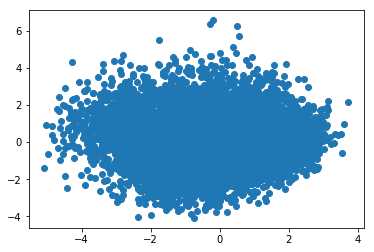

Input shape: (9,)
(10000, 9) (1000, 9)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 9)                 90        
_________________________________________________________________
dense_2 (Dense)              (None, 512)               5120      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_4 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_6 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_7 (Dense)              (None, 1

In [5]:
# Network input selection

# no preprocessing - 44.8% flattened images, 52.9% hog features. 
#x_train, x_test, input_shape = trnImage, testImage, trnImage[0].shape
#x_train, x_test, input_shape = trn_hog_feature, test_hog_feature, trn_hog_feature[0].shape

# kmeans - 30.1% flattened images, 39.1% hog features.
#x_train, x_test, input_shape = trnImage_km, testImage_km, trnImage_km[0].shape
#x_train, x_test, input_shape = trn_hog_km, test_hog_km, trn_hog_km[0].shape

# pca - 34.1% flattened images, 45.2% hog features.
#x_train, x_test, input_shape = trnImage_pca, testImage_pca, trnImage_pca[0].shape
#x_train, x_test, input_shape = trn_hog_pca, test_hog_pca, trnImage_pca[0].shape

# lda - 23.5% flattened images, 49.6% hog features.
#x_train, x_test, input_shape = trnImage_lda, testImage_lda, trnImage_lda[0].shape
x_train, x_test, input_shape = trn_hog_lda, test_hog_lda, trn_hog_lda[0].shape

plt.scatter(x_train[:, 0], x_train[:, 1])
plt.show()

print("Input shape:", input_shape)
print(x_train.shape, x_test.shape)

# model definition
# using the same model for hog and flattened images
model = Sequential()
model.add(Dense(input_shape[0], input_shape=input_shape))
model.add(Dense(512, activation="relu"))
model.add(Dense(128))
model.add(Dense(512, activation="relu"))
model.add(Dense(128))
model.add(Dense(512, activation="relu"))
model.add(Dense(num_classes, activation="softmax"))

# optimizer
adam = Adam(1e-4)
model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])
print(model.summary())

In [6]:
# Warning: Results may vary slightly.
start = time.time()
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32)
loss, acc = model.evaluate(x_test, y_test)
y_pred = model.predict(x_test)
print("{:.2f} seconds elapsed".format(time.time() - start))
print("Accuracy: {0:.2f}%".format(acc*100))

Train on 10000 samples, validate on 1000 samples
Epoch 1/50
10000/10000 [==============================] - 2s 205us/step - loss: 1.6306 - acc: 0.4509 - val_loss: 1.5289 - val_acc: 0.4700
Epoch 2/50
10000/10000 [==============================] - 1s 103us/step - loss: 1.3560 - acc: 0.5207 - val_loss: 1.5248 - val_acc: 0.4880
Epoch 3/50
10000/10000 [==============================] - 1s 108us/step - loss: 1.3346 - acc: 0.5289 - val_loss: 1.5084 - val_acc: 0.4770
Epoch 4/50
10000/10000 [==============================] - 1s 104us/step - loss: 1.3180 - acc: 0.5334 - val_loss: 1.4979 - val_acc: 0.4840
Epoch 5/50
10000/10000 [==============================] - 1s 107us/step - loss: 1.3020 - acc: 0.5383 - val_loss: 1.4991 - val_acc: 0.4700
Epoch 6/50
10000/10000 [==============================] - 1s 106us/step - loss: 1.2830 - acc: 0.5478 - val_loss: 1.4885 - val_acc: 0.4860
Epoch 7/50
10000/10000 [==============================] - 1s 104us/step - loss: 1.2660 - acc: 0.5540 - val_loss: 1.4856 - v

# Results and Graphing

Confusion matrix, without normalization
[[62  3  7  0  5  2  4  2 10  5]
 [ 4 53  1  4  5  2  5  3  8 15]
 [ 8  3 36  4  6 19 12  3  6  3]
 [ 3  5 16 27 14 11 15  7  0  2]
 [ 6  2 11 12 50  4  8  4  0  3]
 [ 3  3  9 12  8 48  8  6  0  3]
 [ 1  3 10  8  8  8 52  8  0  2]
 [ 1  3  4  7 14  6  3 55  2  5]
 [17 15  3  2  3  0  0  0 51  9]
 [ 6 10  1  0  3  2  1  5  6 66]]


<Figure size 432x288 with 0 Axes>

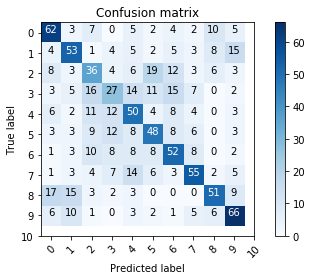

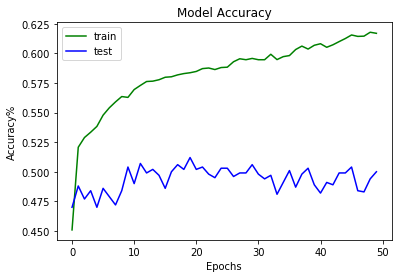

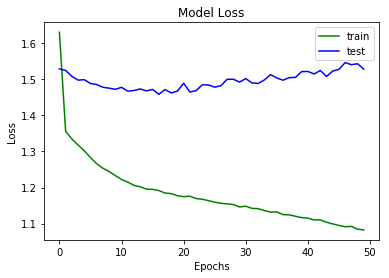

In [7]:
# Graphs and Plots

# confusion_matrix plotting code sourced from
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# print the confusion matrix from the history object
confusion = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
fig = plt.figure()
plt.figure()
plot_confusion_matrix(confusion, classes=range(num_classes))
#plt.savefig("conf_none_1.png")

# plot the loss function and the accuracy over time
plt.figure()
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy%")
plt.plot(hist.history['acc'], c="green")
plt.plot(hist.history['val_acc'], c="blue")
plt.legend(["train", "test"])
#plt.savefig("acc_none_1.png")

plt.figure()
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(hist.history['loss'], c="green")
plt.plot(hist.history['val_loss'], c="blue")
plt.legend(["train", "test"])
plt.savefig("loss_lhog.png")
plt.show()

In [8]:
print(tf.test.is_gpu_available())
from platform import node
print(node())
# Question: How does the depth of a neural network affect accuracy and training time?
# George is taking that.
# New question: How does the preprocessing applied to data affect neural network accuracy and training time?

True
karen


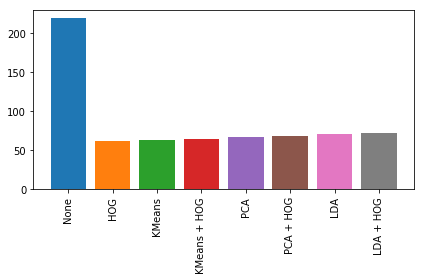

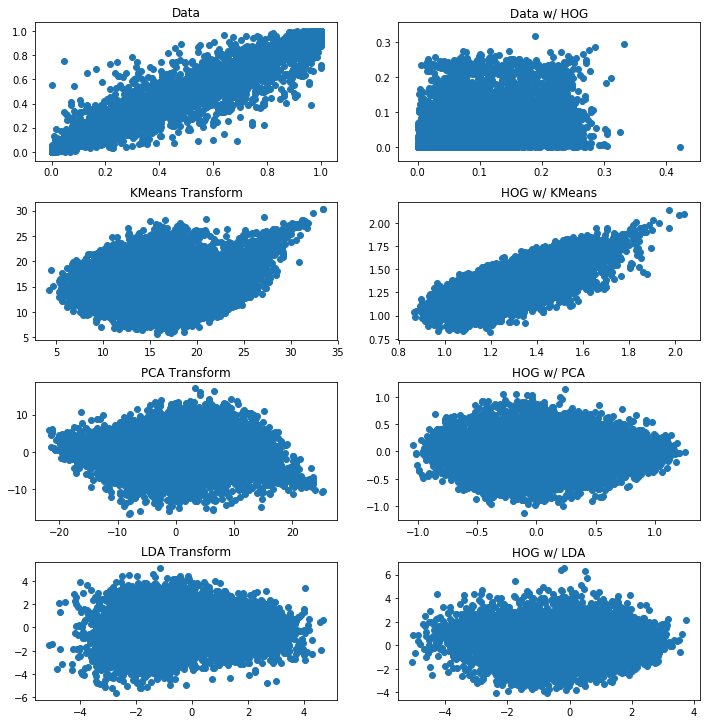

In [9]:
def plot_datasets():
    data = {
        "Data": trnImage, 
        "Data w/ HOG": trn_hog_feature,
        "KMeans Transform": trnImage_km,
        "HOG w/ KMeans": trn_hog_km,
        "PCA Transform": trnImage_pca,
        "HOG w/ PCA": trn_hog_pca, 
        "LDA Transform": trnImage_lda,        
        "HOG w/ LDA": trn_hog_lda
    }
    fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(10,10))
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3, wspace=0.2)
    for i,k in enumerate(data):
        subfig = plt.subplot(4, 2,i+1)
        d = data[k]
        plt.title(k)
        plt.scatter(d[:, 0], d[:, 1])
        
def plot_time():
    # times collected from all the test runs.
    mean_times = {
        "None": 218.3,
        "HOG": 61.5,
        "KMeans": 62.5,
        "KMeans + HOG": 64.7,
        "PCA": 66.8,
        "PCA + HOG": 68.6,
        "LDA": 70.6,
        "LDA + HOG": 72.32
    }
    # just put whatever it is into a bar, i guess
    fig, ax = plt.subplots()
    
    # matplotlib is silly
    keys, x = [], 0
    for key in mean_times:
        keys.append(key)
        x += 1
        
    # print bars for days
    for idx, key in enumerate(mean_times):
        val = mean_times[key]
        plt.bar(idx, height=val)
    ax.set_xticks(range(x))
    ax.set_xticklabels(keys, rotation="vertical")
    plt.tight_layout()

# use keras to plot things.
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_data.png')

plot_time()
plt.savefig("time.png")
        

plot_datasets()
plt.savefig("data.png")
plt.show()